# Github Data Analysis
* Sean Smith <swsmith@bu.edu> 
* Ann Ming Samborski <asambors@bu.edu>

# Questions We Strive to Address
1. What are the most popular coding languages? How has this changed over time? How does this data compare to StackOverflow?
2. Given the features shown below, can we predict number of stars? 
3. Is there a specific subset of the features below (besides the entirety) that optimizes the accuracy of star prediction? 
4. Does lines of code correlate with number of stars?
5. Do number of contributors correlate with number of stars?

# Differences From Our Initial Report
In our initial report submission, we focused on the popularity of languages and spoke mainly about how we'd like to study the rise and fall of different languages as a function of time. However, we realize that while we would love to compare GitHub's data to StackOverflow [1], there was still a lot more that we could do with the data collected. 

In addition to our desire to study different questions about the GitHub data, we also realized there is a slight skew to our collected data. It is reporting that the most common language is Ruby, but according to Stack Overflow surveys, JavaScript should have been the most popular. We only have a portion of GitHub's repositories so we cannot be certain one way or the other of which language is in fact most popular. Due to this inaccuracy, we decided to focus our efforts in another direction.

That being said, we now switch over to a focus on stars. We would like to see what combination of feature vectors (features shown below) can be used to best predict the number of stars a repository will have. Clearly, we would like to explore how to best minimize features required (i.e. is a question like (**2**) above a fair one to ask? Is it possible that one feature can be enough information to predict on?).

# References
1. [Stack Overflow Most Popular Languages 2017](https://stackoverflow.com/insights/survey/2017#technology-programming-languages)
2. [Pandas Scatter Plot](http://pandas.pydata.org/pandas-docs/stable/visualization.html#scatter-plot)
3. [Sampling](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html)

## Dataset
We collected `137,100` repositories. We recognize more data would have been ideal, but the GitHub API rate limit, even with that increased thanks to GitHub Support, still restricts the amount of information we can make (especially because 1 repository requires 2 additional API calls). The information collected per repository is below.

| Name          | Description   |
| ------------- |:--------------|
| name          | Owner/Repository name |
| owner         | Owner name |
| watchers      | Number of watchers |
| stars         | Number of stars |
| forks         | Number of forks |
| type          | Type of account, organization or user |
| issues        | Number of issues|
| created_at    | Date created |
| pushed_at     | Date last pushed |
| updated_at    | Date last updated |
| size          | Size of repo in KB|
| open_issues   | Number of open issues |
| description   | Repository description |
| num_languages | Number of programming languages |
|language_1     | Most popular language |
|language_1_size| Most popular language size in bytes |
|language_2     | Second most popular language |
|language_2_size| Second most popular language size in bytes |
|language_3     | Third most popular language |
|language_3_size| Third most popular language size in bytes |

## Data Collection Code

Please see our initial report on our data and how we collected it for fleshed out details. 

## Data

In [2]:
# INCLUDES
import requests
from pprint import pprint
import collections
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
%matplotlib inline

import json
import random
import re
import numpy as np 
from datetime import datetime
import warnings
import sklearn

import matplotlib.cm as cm
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import scale
from sklearn.preprocessing import Normalizer
import sklearn.metrics as metrics
import scipy.sparse.linalg as linalg
from sklearn import preprocessing

from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn.model_selection as cross_validation

# IGNORE WARNINGS
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning)

In [3]:
# Read in data
df = pd.read_csv('github_data.csv')

In [4]:
df.head(5)

,name,owner,watchers,stars,forks,type,issues,created_at,pushed_at,updated_at,size,open_issues_count,description,num_languages,language_1,language_1_size,language_2,language_2_size,language_3,language_3_size
0,mojombo/grit,mojombo,59,1883,451,User,3,2007-10-29T14:37:16Z,2016-08-01T15:17:38Z,2017-04-19T11:01:12Z,7954,3,**Grit is no longer maintained. Check out libg...,1,Ruby,219981.0,NaN,NaN,NaN,NaN
1,wycats/merb-core,wycats,3,407,54,User,0,2008-01-12T05:50:53Z,2008-10-13T02:31:34Z,2017-04-23T16:05:54Z,3462,0,Merb Core: All you need. None you don't.,2,Ruby,948883.0,JavaScript,8925.0,NaN,NaN
2,rubinius/rubinius,rubinius,120,2692,612,Organization,211,2008-01-12T16:46:52Z,2017-04-22T23:00:00Z,2017-04-23T09:34:21Z,162886,211,The Rubinius Language Platform,13,Ruby,7352918.0,C++,2917738.0,C,522111.0
3,mojombo/god,mojombo,104,2036,479,User,112,2008-01-13T05:16:23Z,2017-03-01T00:00:23Z,2017-04-23T14:44:01Z,2639,112,Ruby process monitor,6,Ruby,283939.0,C,9261.0,CSS,6486.0
4,vanpelt/jsawesome,vanpelt,2,36,2,User,0,2008-01-13T06:04:19Z,2008-05-29T20:09:36Z,2017-03-29T18:09:21Z,192,0,Awesome JSON,2,JavaScript,126588.0,Ruby,9677.0,NaN,NaN


In [5]:
df.shape

(137100, 20)

In [6]:
df.type.value_counts()

User            130069
Organization      7031
Name: type, dtype: int64

## Most Popular Programming Language

In [7]:
# Top 20
df.language_1.value_counts()[:20]

Ruby            36351
JavaScript      15032
Python          11333
PHP              7484
Java             6384
C                6070
Perl             5027
C++              4391
Objective-C      2852
C#               2158
Shell            1999
Emacs Lisp       1802
VimL             1254
ActionScript     1072
Erlang            976
Haskell           900
Scala             774
Clojure           718
Lua               677
Common Lisp       520
Name: language_1, dtype: int64

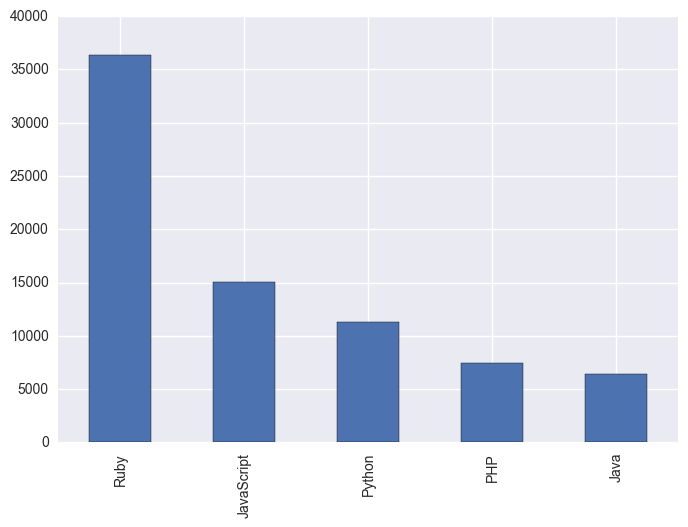

In [8]:
df.language_1.value_counts()[:5].plot.bar()

In [9]:
ruby_popularity = df[df.language_1 == 'Ruby'].filter(['language_1_size', 'created_at'])

Min: 2007-10-29T14:37:16Z
Max: 2010-06-24T18:44:50Z


(0, 20000000)

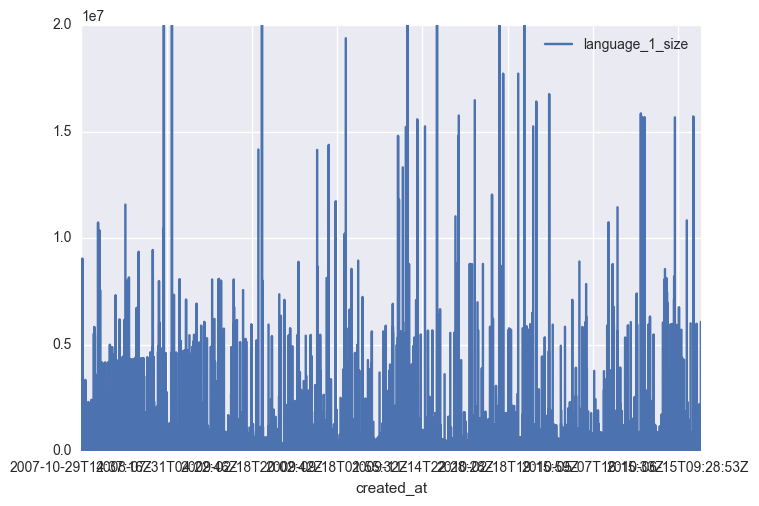

In [10]:
# import matplotlib.pyplot as plt
# axes = plt.subplot()
print("Min: %s" % ruby_popularity.created_at.min())
print("Max: %s" % ruby_popularity.created_at.max())

# bins = ruby_popularity.created_at.hist(bins=10)
# bins[0][0].x_label('created_at')
plt = ruby_popularity.plot(x='created_at', y='language_1_size')
plt.set_ylim([0,20000000])

# Forks vs Stars

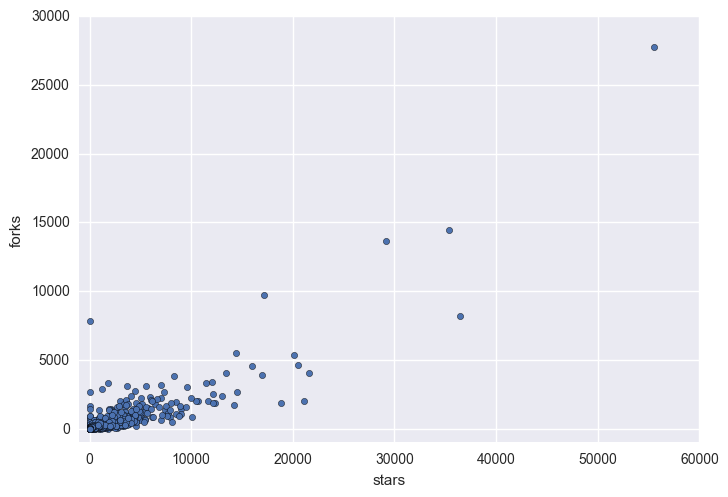

In [11]:
df.plot.scatter(x='stars', y='forks', xlim=[-1000,60000], ylim=[-1000,30000])

# Can we predict the number of stars a repository has?

In [12]:
# I am dumb, we need the stars

In [13]:
# Eliminate feature vectors that will not aid in the prediction of stars
guess_stars = df[['watchers', 'stars', 'forks', 'type', 'issues', 'size', 
                  'open_issues_count', 'num_languages', 'language_1', 
                  'language_1_size', 'language_2', 'language_2_size', 
                  'language_3', 'language_3_size']]
guess_stars.head(10)

,watchers,stars,forks,type,issues,size,open_issues_count,num_languages,language_1,language_1_size,language_2,language_2_size,language_3,language_3_size
0,59,1883,451,User,3,7954,3,1,Ruby,219981.0,NaN,NaN,NaN,NaN
1,3,407,54,User,0,3462,0,2,Ruby,948883.0,JavaScript,8925.0,NaN,NaN
2,120,2692,612,Organization,211,162886,211,13,Ruby,7352918.0,C++,2917738.0,C,522111.0
3,104,2036,479,User,112,2639,112,6,Ruby,283939.0,C,9261.0,CSS,6486.0
4,2,36,2,User,0,192,0,2,JavaScript,126588.0,Ruby,9677.0,NaN,NaN
5,2,66,5,User,0,156,0,1,JavaScript,48977.0,NaN,NaN,NaN,NaN
6,1,239,86,User,2,232,2,2,Ruby,10936.0,JavaScript,1531.0,NaN,NaN
7,2,151,16,User,1,473,1,2,Ruby,21237.0,JavaScript,2032.0,NaN,NaN
8,16,1629,283,User,27,1208,27,1,Ruby,145649.0,NaN,NaN,NaN,NaN
9,7,1036,309,User,37,1008,37,1,Ruby,132960.0,NaN,NaN,NaN,NaN


In [14]:
# Take a random sampling of the dataframe becuase every time I try to run it on the full dataset, 
# my kernel crashes and then so does my computer  
random_sampling = guess_stars.sample(frac=0.33, replace=True)
random_sampling.shape

(45243, 14)

In [21]:
random_sampling = random_sampling.replace(np.NaN, 0)
random_sampling.head(10)

,watchers,stars,forks,type,issues,size,open_issues_count,num_languages,language_1,language_1_size,language_2,language_2_size,language_3,language_3_size
96697,1,1,1,User,0,146,0,0,Ruby,0.0,0,0.0,0,0.0
66721,2,2,1,User,1,132,1,1,Perl,10561.0,0,0.0,0,0.0
14173,3,8,2,User,0,270,0,2,Ruby,16419.0,Objective-C,290.0,0,0.0
6353,2,2,0,User,0,89,0,1,Ruby,246.0,0,0.0,0,0.0
44984,2,1,1,User,0,190,0,0,Ruby,0.0,0,0.0,0,0.0
30530,2,1,0,User,0,116,0,0,0,0.0,0,0.0,0,0.0
102939,0,1,1,User,0,810,0,0,Ruby,0.0,0,0.0,0,0.0
12886,2,2,1,User,0,2741,0,0,Ruby,0.0,0,0.0,0,0.0
47604,2,1,0,User,0,184,0,2,Ruby,29416.0,JavaScript,148.0,0,0.0
33987,1,2,0,User,0,76,0,0,0,0.0,0,0.0,0,0.0


In [5]:
# Retrieve dummies
to_dummy = ['type', 'language_1', 'language_2', 'language_3']
df_dummies = pd.get_dummies(data=random_sampling, columns=to_dummy)
df_dummies.head(3)

,Unnamed: 0,watchers,stars,forks,issues,size,open_issues_count,num_languages,language_1_size,language_2_size,...,language_3_Verilog,language_3_Vim script,language_3_VimL,language_3_Visual Basic,language_3_Vue,language_3_XML,language_3_XS,language_3_XSLT,language_3_Yacc,language_3_ooc
0,96697,1,1,1,0,146,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66721,2,2,1,1,132,1,1,10561.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14173,3,8,2,0,270,0,2,16419.0,290.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
random_sampling.shape

(45243, 14)

In [121]:
estimate_stars_sample = df_dummies.drop(['stars'], 1)
estimate_stars_sample.head(5)

,watchers,forks,issues,size,open_issues_count,num_languages,language_1_size,language_2_size,language_3_size,type_Organization,...,language_3_Verilog,language_3_Vim script,language_3_VimL,language_3_Visual Basic,language_3_Vue,language_3_XML,language_3_XS,language_3_XSLT,language_3_Yacc,language_3_ooc
96697,1,1,0,146,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66721,2,1,1,132,1,1,10561.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14173,3,2,0,270,0,2,16419.0,290.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6353,2,0,0,89,0,1,246.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44984,2,1,0,190,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
stars_sample = pd.DataFrame(df_dummies['stars'], columns=['stars'])
stars_sample.head(5)

,stars
96697,1
66721,2
14173,8
6353,2
44984,1


In [25]:
print(stars_sample.max())
print(stars_sample.min())
print(df.loc[df['stars'] < 0].name) 

stars    55540
dtype: int64
stars    0
dtype: int64
46378                       sonian/sweat_shop
46380                      sonian/is_paranoid
66892    ubik86/rspec-haml-scaffold-generator
Name: name, dtype: object


You'll notice that it claims that some of these repositories have negative stars, which we previously believed to be impossible. However, besides `sweat_shop` (where I clicked the star and moved the value from -2 to 1, unstarred and it returned to 0), you can see that the stars truly are in the negatives.

## Visualizations 

In [106]:
# Create histogram bins

def histogram(data, bins, max_stars, start):
    d = []
    for i in range(start, math.ceil(max_stars / bins)):
        min_stars = i * bins
        max_stars = (i + 1) * bins
        m = {}
        m['Bin'] = "%d-%d" % (min_stars, max_stars)
        m['Values'] = len(data.loc[(data.stars >= min_stars) & (data.stars < max_stars)])
        d.append(m)
    return d

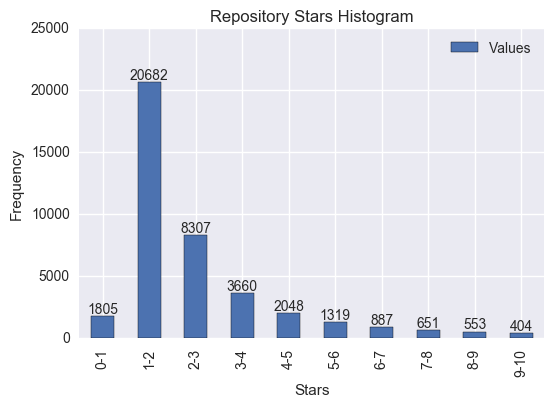

In [135]:
d = histogram(stars_sample, 1, 10, 0)
stars_hist = pd.DataFrame(d)
ax = stars_hist.plot(x='Bin', y='Values', kind='bar')
ax.set_title("Repository Stars Histogram")
ax.set_xlabel("Stars")
ax.set_ylabel("Frequency")

# Now make some labels
labels = stars_hist.Values

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.savefig('hist_10.png')

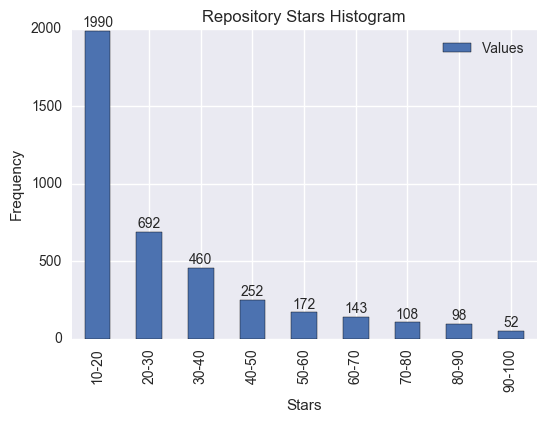

In [136]:
d = histogram(stars_sample, bins=10, max_stars=100, start=1)
stars_hist = pd.DataFrame(d)
ax = stars_hist.plot(x='Bin', y='Values', kind='bar')
ax.set_title("Repository Stars Histogram")
ax.set_xlabel("Stars")
ax.set_ylabel("Frequency")

# Now make some labels
labels = stars_hist.Values

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('hist_1000.png')

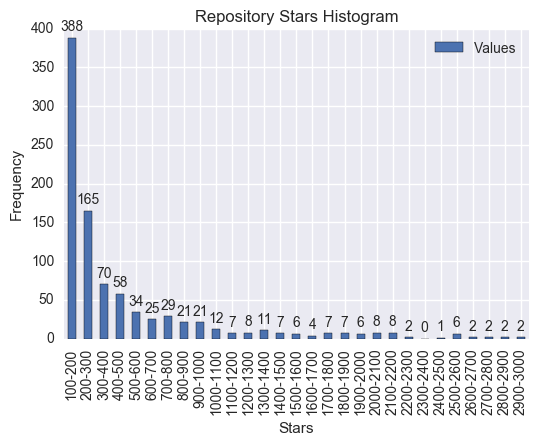

In [134]:
d = histogram(stars_sample, bins=100, max_stars=3000, start=1)
stars_hist = pd.DataFrame(d)
ax = stars_hist.plot(x='Bin', y='Values', kind='bar')
ax.set_title("Repository Stars Histogram")
ax.set_xlabel("Stars")
ax.set_ylabel("Frequency")

# Now make some labels
labels = stars_hist.Values

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.savefig('hist_3000.png')

Above are the graphs representing the repositories that have 0-3000 stars. Graphs are broken down into different ranges for ease of viewing. 

In [233]:
print("Stars Description:\n", stars_sample['stars'].describe())

Stars Description:
 count    45243.000000
mean        19.671220
std        330.913662
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max      55540.000000
Name: stars, dtype: float64


# RELOAD SAMPLE SET HERE FOR CONSISTENCY

In [130]:
# Save current stars_sample 
random_sampling.to_csv('random_sampling.csv')

In [3]:
# Load current random_sampling if doesn't exist
try:
    print(len(random_sampling))
except:
    random_sampling = pd.read_csv('random_sampling.csv')

In [17]:
# df_dummies[:10]

u, s, vt = np.linalg.svd(df_dummies[:10000])

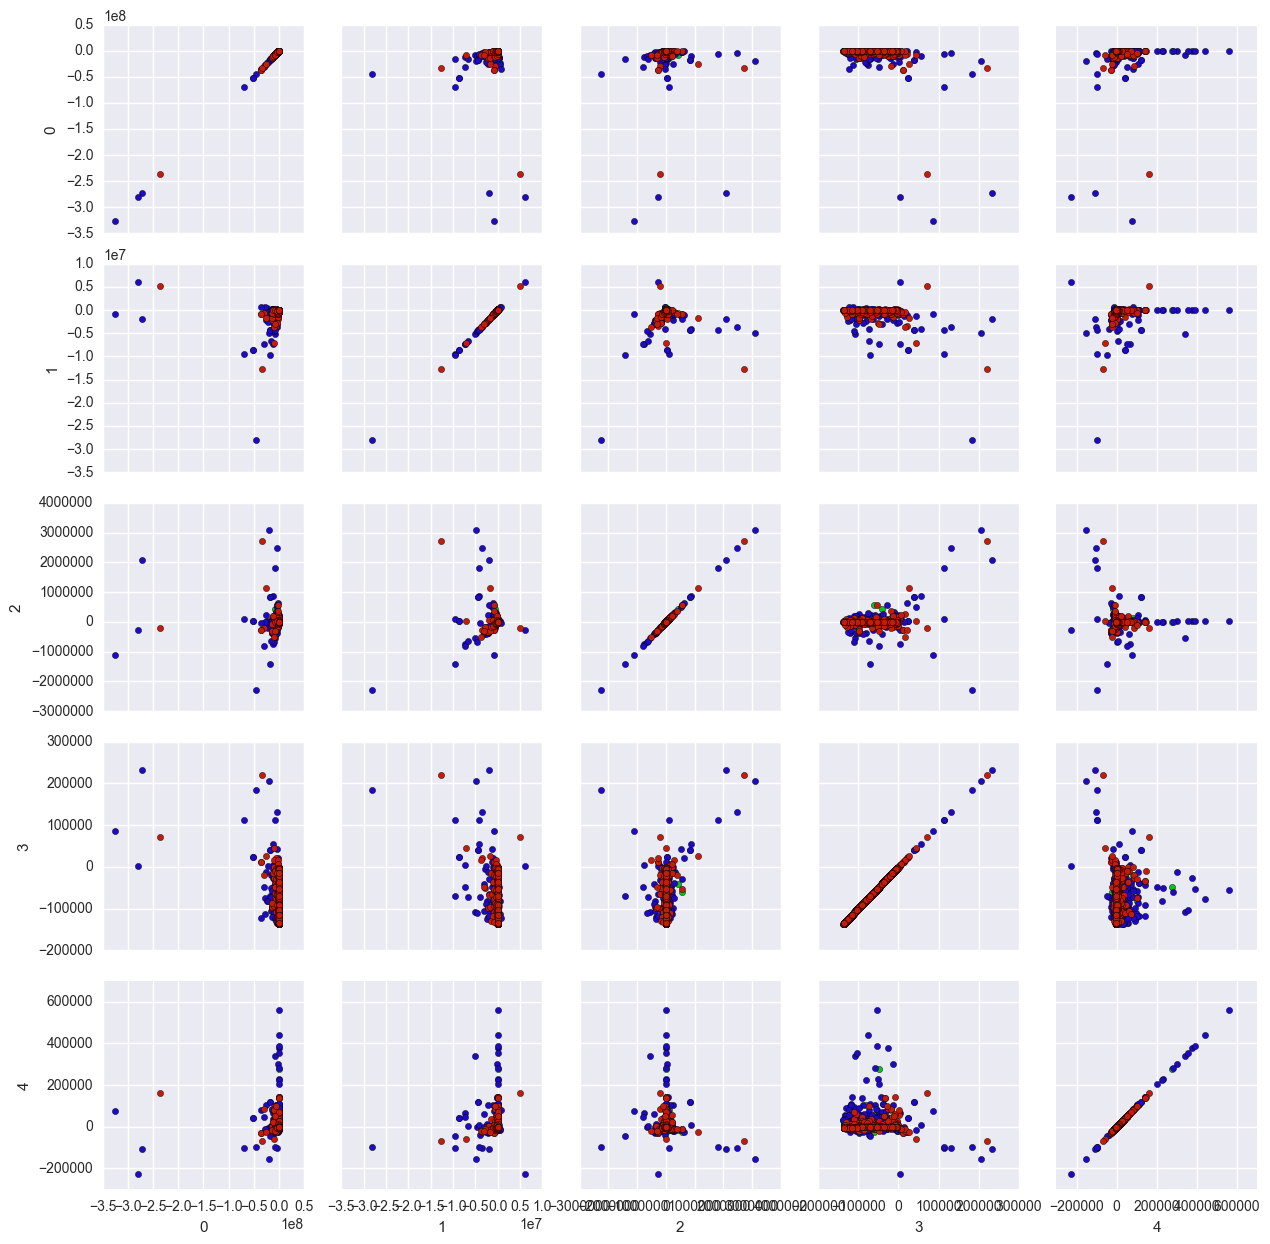

In [18]:
k = 5
Xk = u[:,:k] @ np.diag(s[:k])
X_df = pd.DataFrame(Xk)
g = sns.PairGrid(X_df)
def pltColor(x,y,label,color):
    cmap = sns.hls_palette(n_colors=3, h=0.35, l=0.4, s=0.9)
    for i in range(3):
        point_indices = np.where(df_dummies.stars == i)[0]
        point_indices = point_indices.tolist()
        plt.scatter(x[point_indices], y[point_indices], c=cmap[i])
    sns.despine()
g.map(pltColor)

## K-Nearest Neighbors

In [141]:
X_train, X_test, y_train, y_test = train_test_split(estimate_stars_sample, stars_sample, test_size=0.4, random_state=0)

In [174]:
print(stars_sample.max())
print(stars_sample.min())

stars    55540
dtype: int64
stars    0
dtype: int64


In [144]:
acc = []
for k in range(15,50):
    knn_digits = KNeighborsClassifier(n_neighbors=k)
    knn_digits.fit(X_train, pd.Series.ravel(y_train))
    y_digits_test_pred = knn_digits.predict(X_test)
    print("KNN test accuracy on prediction >50K, k = {}, acc = {}: ".format(
            k,knn_digits.score(X_test, y_test)))
    acc.append(knn_digits.score(X_test, y_test))

KNN test accuracy on prediction >50K, k = 15, acc = 0.4398276052602498: 
KNN test accuracy on prediction >50K, k = 16, acc = 0.4398276052602498: 
KNN test accuracy on prediction >50K, k = 17, acc = 0.4397170958116919: 
KNN test accuracy on prediction >50K, k = 18, acc = 0.44004862415736545: 
KNN test accuracy on prediction >50K, k = 19, acc = 0.4409879544701072: 
KNN test accuracy on prediction >50K, k = 20, acc = 0.442645596198475: 
KNN test accuracy on prediction >50K, k = 21, acc = 0.44347441706265883: 
KNN test accuracy on prediction >50K, k = 22, acc = 0.4435849265112167: 
KNN test accuracy on prediction >50K, k = 23, acc = 0.44347441706265883: 
KNN test accuracy on prediction >50K, k = 24, acc = 0.4449662946181899: 
KNN test accuracy on prediction >50K, k = 25, acc = 0.4473975024864626: 
KNN test accuracy on prediction >50K, k = 26, acc = 0.4490551442148304: 
KNN test accuracy on prediction >50K, k = 27, acc = 0.4491103989391093: 
KNN test accuracy on prediction >50K, k = 28, acc

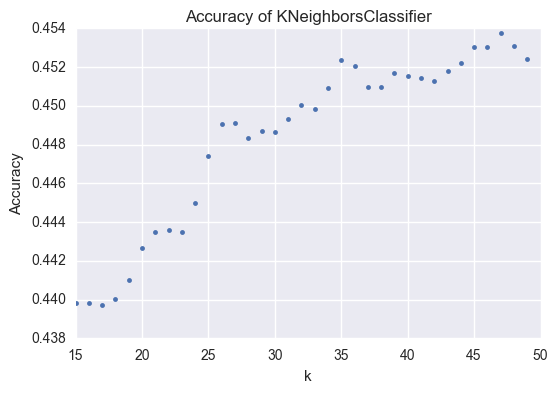

In [169]:
# ACCURACY PLOT OF KNEIGHBORS
x_data = [i for i in range(15,50)]
plt.plot(x_data, acc,'.')
plt.xlabel('k')
_=plt.ylabel('Accuracy')
plt.title("Accuracy of KNeighborsClassifier")
plt.savefig('knn_acc.png')
plt.show()

In [171]:
max(acc)

0.45375179577853908

In [172]:
knneighbors = KNeighborsClassifier(n_neighbors=47)
knneighbors.fit(X_train, pd.Series.ravel(y_train))
y_pred_test = knneighbors.predict(X_test)

print('Accuracy on test data: {}'.format(knneighbors.score(X_test, y_test)))

Accuracy on test data: 0.4537517957785391


In [173]:
y_pred_train = knneighbors.predict(X_train)
print('Accuracy on training data: {}'.format(knneighbors.score(X_train, y_train)))

Accuracy on training data: 0.4638054890403389


## Discussion of Results on K-Nearest Neighbors 
While the accuracy of the test data appears to be low (coming in at only 45.4%), it is actually higher than we anticipated. If you consider what we are asking the algorithm to predict, it is solidly more impressive. The number of stars has no hard maximum. The minimum in this particular subset of the data is 0, and the maximum is 55540. The size of this space is large, and having an algorithm predict the correct integer star amount with 45.4% accuracy is in fact quite good.

## Decision Tree

In [176]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_test = dtc.predict(X_test)
print('DT accuracy on test data: ', dtc.score(X_test, y_test))
y_pred_train = dtc.predict(X_train)
print('DT accuracy on training data: ', dtc.score(X_train, y_train))

DT accuracy on test data:  0.485965300033
DT accuracy on training data:  0.960250506539


In [186]:
# LITERALLY RAN FOR OVER 30 MIN AND NOTHING
# JUST TOO BIG TO CREATE IMAGE
# import pydotplus
# start = time.time()
# dot_data = tree.export_graphviz(dtc, out_file=None) 
# graph = pydotplus.graph_from_dot_data(dot_data) 
# graph.write_pdf("dtc.pdf") 
# print("finished in %d seconds" % (time.time()-start))

## Decision Tree Regressor

In [220]:
# Need to transform to floats for regression for some reason
y_train.stars = y_train.stars.astype(float)

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4018)
KeyboardInterrupt
/Users/asambors/anaconda3/envs/pyv3.2/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [231]:
y_train.head()

,stars
18794,4.0
128871,1.0
38463,3.0
65380,1.0
110229,1.0


In [232]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
print('DT accuracy on test data: ', clf.score(X_test, y_test))
y_pred_train = dtc.predict(X_train)
print('DT accuracy on training data: ', clf.score(X_train, y_train))

DT accuracy on test data:  0.473880075464
DT accuracy on training data:  0.999996042305


## Logistical Regression Model

In [241]:
# Label encode stars as labels to be predicted
label_encoder = preprocessing.LabelEncoder()
encoded_stars = label_encoder.fit_transform(stars_sample['stars'])

# Split training and test
X_train, X_test, y_train, y_test = train_test_split(estimate_stars_sample, encoded_stars, test_size = 0.3, random_state = 0)

In [242]:
print(len(X_train))
print(len(y_train))

31670
31670


In [243]:
# Logistic Regression
X_train['Intercept'] = 1.0
X_test['Intercept'] = 1.0

log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)
    
print("Logistic Regression Accuracy (70/30 split):\n Accuracy: ", metrics.accuracy_score(y_test, log_reg_preds))

/Users/asambors/anaconda3/envs/pyv3.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/asambors/anaconda3/envs/pyv3.2/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Logistic Regression Accuracy (70/30 split):
 Accuracy:  0.443232888823


In [244]:
print("Logistic Regression Confusion Matrix:\n", metrics.confusion_matrix(Y_test, log_reg_preds))

Logistic Regression Confusion Matrix:
 [[   0  550    0 ...,    0    0    0]
 [   0 6016    4 ...,    0    0    0]
 [   0 2373    0 ...,    0    0    0]
 ..., 
 [   0    0    0 ...,    0    0    0]
 [   0    1    0 ...,    0    0    0]
 [   0    1    0 ...,    0    0    0]]


In [245]:
print("Logistic Regression report:\n", metrics.classification_report(Y_test, log_reg_preds))

Logistic Regression report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       569
          1       0.46      0.97      0.62      6210
          2       0.00      0.00      0.00      2436
          3       0.00      0.00      0.00      1107
          4       0.00      0.00      0.00       610
          5       0.00      0.00      0.00       404
          6       0.00      0.00      0.00       281
          7       0.00      0.00      0.00       187
          8       0.00      0.00      0.00       156
          9       0.00      0.00      0.00       129
         10       0.00      0.00      0.00       101
         11       0.00      0.00      0.00        90
         12       0.00      0.00      0.00        89
         13       0.00      0.00      0.00        60
         14       0.00      0.00      0.00        56
         15       0.00      0.00      0.00        54
         16       0.00      0.00      0.00        43
         17     

/Users/asambors/anaconda3/envs/pyv3.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/asambors/anaconda3/envs/pyv3.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [249]:
# Cross Validation
# It takes forever to run I don't know why D: 
# log_scores = cross_validation.cross_val_score(LogisticRegression(), estimate_stars_sample, 
#                                               encoded_stars, scoring='accuracy', cv=10)
# print("Logistic Regression Log Scores: %d" % log_scores)
# print("Logistic Regression Log Scores Mean: %d" % log_scores.mean())

# Subset of Feature Vectors: Can it produce the same accuracy if not better than the previous? 

We want to explore if there is any change without the presence of languages. We hypothesize that the removal of these feature vectors will not make a huge difference. In fact, we would claim that the most important features are watchers and forks. We will test this theory further below on a few less computationally intensive prediction algorithms (decision tree and KNN).

In [267]:
without_languages = df[['watchers', 'stars', 'forks', 'type', 'issues', 'size', 'open_issues_count']]

In [273]:
# Will return to this if study below is not fruitful

# Using the Amount of Stars from a Repository to Predict its Top Language 

In [292]:
guess_primary_language = df[['watchers', 'stars', 'forks', 'type', 'issues', 'size', 
                  'open_issues_count', 'num_languages', 'language_1']]
guess_primary_language.head(10)

,watchers,stars,forks,type,issues,size,open_issues_count,num_languages,language_1
0,59,1883,451,User,3,7954,3,1,Ruby
1,3,407,54,User,0,3462,0,2,Ruby
2,120,2692,612,Organization,211,162886,211,13,Ruby
3,104,2036,479,User,112,2639,112,6,Ruby
4,2,36,2,User,0,192,0,2,JavaScript
5,2,66,5,User,0,156,0,1,JavaScript
6,1,239,86,User,2,232,2,2,Ruby
7,2,151,16,User,1,473,1,2,Ruby
8,16,1629,283,User,27,1208,27,1,Ruby
9,7,1036,309,User,37,1008,37,1,Ruby


In [300]:
guess_primary_language.shape

(137100, 9)

In [301]:
# Eliminate the NaN
guess_primary_language_no_na = guess_primary_language.dropna(axis=0)
guess_primary_language_no_na.shape

(111404, 9)

In [306]:
unique_1st_languages = guess_primary_language_no_na['language_1'].unique()

In [331]:
# Unique values of the languages
unique_1st_languages = list(unique_1st_languages)
langs = {}
for i, lang in enumerate(unique_1st_languages):
    langs[lang] = i
langs

{'AGS Script': 135,
 'ASP': 56,
 'ActionScript': 2,
 'Ada': 83,
 'ApacheConf': 89,
 'AppleScript': 87,
 'Arc': 5,
 'Arduino': 133,
 'Assembly': 47,
 'Augeas': 65,
 'AutoHotkey': 93,
 'Awk': 59,
 'Batchfile': 49,
 'BitBake': 129,
 'Boo': 40,
 'Brightscript': 125,
 'Bro': 53,
 'C': 3,
 'C#': 25,
 'C++': 18,
 'CLIPS': 114,
 'CMake': 121,
 'CSS': 9,
 'ChucK': 82,
 'Clean': 113,
 'Clojure': 33,
 'CoffeeScript': 60,
 'ColdFusion': 72,
 'Common Lisp': 13,
 'Component Pascal': 124,
 'Crystal': 74,
 'Cucumber': 115,
 'D': 45,
 'Dart': 117,
 'Diff': 142,
 'Eagle': 107,
 'Eiffel': 61,
 'Elixir': 92,
 'Emacs Lisp': 6,
 'Erlang': 4,
 'F#': 62,
 'FORTRAN': 102,
 'Factor': 54,
 'Fancy': 128,
 'Forth': 29,
 'Fortran': 51,
 'GAP': 123,
 'GDB': 100,
 'GLSL': 119,
 'Game Maker Language': 130,
 'Go': 48,
 'Gosu': 91,
 'Graphviz (DOT)': 138,
 'Groff': 55,
 'Groovy': 30,
 'HTML': 10,
 'Hack': 120,
 'Haskell': 32,
 'Haxe': 78,
 'IDL': 105,
 'Io': 8,
 'Java': 16,
 'JavaScript': 1,
 'Jupyter Notebook': 23,
 'K

In [308]:
unique_lang_df = pd.DataFrame(unique_1st_languages)
unique_lang_df.columns = ['language']
unique_lang_df.head()

,language
0,Ruby
1,JavaScript
2,ActionScript
3,C
4,Erlang


In [309]:
unique_lang_df.shape

(143, 1)

In [397]:
# Retrieve dummies
predict_to_dummy = ['type']
df_dummies_lang = pd.get_dummies(data=guess_primary_language_no_na, columns=predict_to_dummy)
df_dummies_lang.head(3)

,watchers,stars,forks,issues,size,open_issues_count,num_languages,language_1,type_Organization,type_User
0,59,1883,451,3,7954,3,1,Ruby,0.0,1.0
1,3,407,54,0,3462,0,2,Ruby,0.0,1.0
2,120,2692,612,211,162886,211,13,Ruby,1.0,0.0


In [398]:
# Data to predict on
estimate_primary_sample = df_dummies_lang.drop(['language_1'], 1)
estimate_primary_sample.head(4)

,watchers,stars,forks,issues,size,open_issues_count,num_languages,type_Organization,type_User
0,59,1883,451,3,7954,3,1,0.0,1.0
1,3,407,54,0,3462,0,2,0.0,1.0
2,120,2692,612,211,162886,211,13,1.0,0.0
3,104,2036,479,112,2639,112,6,0.0,1.0


In [399]:
# Turn language into unique integers
df_dummies_lang['language_1_value'] = df_dummies_lang.language_1.map(langs)

In [400]:
df_dummies_lang.head(5)

,watchers,stars,forks,issues,size,open_issues_count,num_languages,language_1,type_Organization,type_User,language_1_value
0,59,1883,451,3,7954,3,1,Ruby,0.0,1.0,0
1,3,407,54,0,3462,0,2,Ruby,0.0,1.0,0
2,120,2692,612,211,162886,211,13,Ruby,1.0,0.0,0
3,104,2036,479,112,2639,112,6,Ruby,0.0,1.0,0
4,2,36,2,0,192,0,2,JavaScript,0.0,1.0,1


In [401]:
language_sample = pd.DataFrame(df_dummies_lang['language_1_value'])
language_sample.columns = ['language_1']
language_sample.head(5)

,language_1
0,0
1,0
2,0
3,0
4,1


In [402]:
print(estimate_primary_sample.shape)
print(language_sample.columns)

(111404, 9)
Index(['language_1'], dtype='object')


In [408]:
estimate_primary_sample = df_dummies_lang.drop(['language_1_value'], 1)
estimate_primary_sample = estimate_primary_sample.drop(['language_1'], 1)

In [409]:
estimate_primary_sample.head(10)

,watchers,stars,forks,issues,size,open_issues_count,num_languages,type_Organization,type_User
0,59,1883,451,3,7954,3,1,0.0,1.0
1,3,407,54,0,3462,0,2,0.0,1.0
2,120,2692,612,211,162886,211,13,1.0,0.0
3,104,2036,479,112,2639,112,6,0.0,1.0
4,2,36,2,0,192,0,2,0.0,1.0
5,2,66,5,0,156,0,1,0.0,1.0
6,1,239,86,2,232,2,2,0.0,1.0
7,2,151,16,1,473,1,2,0.0,1.0
8,16,1629,283,27,1208,27,1,0.0,1.0
9,7,1036,309,37,1008,37,1,0.0,1.0


In [410]:
language_sample.head(10)

,language_1
0,0
1,0
2,0
3,0
4,1
5,1
6,0
7,0
8,0
9,0


In [411]:
X_train, X_test, y_train, y_test = train_test_split(estimate_primary_sample, language_sample, test_size=0.4, random_state=0)

In [413]:
acc = []
for k in range(15,50):
    knn_digits = KNeighborsClassifier(n_neighbors=k)
    knn_digits.fit(X_train, pd.Series.ravel(y_train))
    y_digits_test_pred = knn_digits.predict(X_test)
    print("KNN test accuracy on prediction of primary language, k = {}, acc = {}: ".format(
            k,knn_digits.score(X_test, y_test)))
    acc.append(knn_digits.score(X_test, y_test))

KNN test accuracy on prediction of primary language, k = 15, acc = 0.3097257753242673: 
KNN test accuracy on prediction of primary language, k = 16, acc = 0.313832413266909: 
KNN test accuracy on prediction of primary language, k = 17, acc = 0.3158745119159822: 
KNN test accuracy on prediction of primary language, k = 18, acc = 0.314774920335712: 
KNN test accuracy on prediction of primary language, k = 19, acc = 0.31697410349625244: 
KNN test accuracy on prediction of primary language, k = 20, acc = 0.3183429828104663: 
KNN test accuracy on prediction of primary language, k = 21, acc = 0.3176473228311117: 
KNN test accuracy on prediction of primary language, k = 22, acc = 0.3182307795879898: 
KNN test accuracy on prediction of primary language, k = 23, acc = 0.3197343027691755: 
KNN test accuracy on prediction of primary language, k = 24, acc = 0.31948745567972714: 
KNN test accuracy on prediction of primary language, k = 25, acc = 0.32137246981733314: 
KNN test accuracy on prediction

In [415]:
acc_2 = []
for k in range(50,75):
    knn_digits = KNeighborsClassifier(n_neighbors=k)
    knn_digits.fit(X_train, pd.Series.ravel(y_train))
    y_digits_test_pred = knn_digits.predict(X_test)
    print("KNN test accuracy on prediction of primary language, k = {}, acc = {}: ".format(
            k,knn_digits.score(X_test, y_test)))
    acc_2.append(knn_digits.score(X_test, y_test))

KNN test accuracy on prediction of primary language, k = 50, acc = 0.3274314438310668: 
KNN test accuracy on prediction of primary language, k = 51, acc = 0.3267133432072169: 
KNN test accuracy on prediction of primary language, k = 52, acc = 0.3273416812530856: 
KNN test accuracy on prediction of primary language, k = 53, acc = 0.32767829092051526: 
KNN test accuracy on prediction of primary language, k = 54, acc = 0.3276334096315246: 
KNN test accuracy on prediction of primary language, k = 55, acc = 0.32788025672097304: 
KNN test accuracy on prediction of primary language, k = 56, acc = 0.3283066289663839: 
KNN test accuracy on prediction of primary language, k = 57, acc = 0.3289125263677573: 
KNN test accuracy on prediction of primary language, k = 58, acc = 0.32889008572326195: 
KNN test accuracy on prediction of primary language, k = 59, acc = 0.3289574076567479: 
KNN test accuracy on prediction of primary language, k = 60, acc = 0.32886764507876665: 
KNN test accuracy on predict

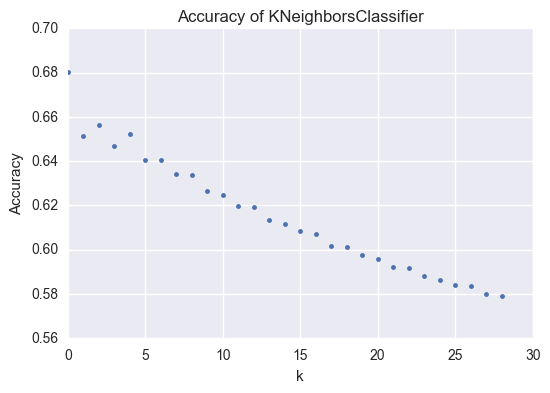

In [390]:
x_labels = [i for i in range(35)]
plt.plot(x_labels, acc, '.')
plt.xlabel('k')
_=plt.ylabel('Accuracy')
plt.title("Accuracy of KNeighborsClassifier")
plt.savefig('knn_acc_lang.png')
plt.show()

## Decision Tree

In [416]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_test = dtc.predict(X_test)
print('DT accuracy on test data: ', dtc.score(X_test, y_test))
y_pred_train = dtc.predict(X_train)
print('DT accuracy on training data: ', dtc.score(X_train, y_train))

DT accuracy on test data:  0.262892150263
DT accuracy on training data:  0.782651626223


emacsmirror	 1 stars	459 repos
emacsattic	 1 stars	184 repos
bitweaver	 5 stars	156 repos
albertobraschi	 1 stars	96 repos
rafl	 4 stars	91 repos
nothingmuch	 6 stars	90 repos
apache	 172 stars	85 repos
drnic	 35 stars	85 repos
textmate	 14 stars	84 repos
edavis10	 40 stars	84 repos
tokuhirom	 5 stars	83 repos
rjbs	 5 stars	80 repos
endevver	 2 stars	75 repos
kristianmandrup	 2 stars	73 repos
jrockway	 7 stars	72 repos
smtlaissezfaire	 7 stars	72 repos
dustin	 28 stars	69 repos
avar	 2 stars	69 repos
bestpractical	 3 stars	68 repos
miyagawa	 28 stars	65 repos


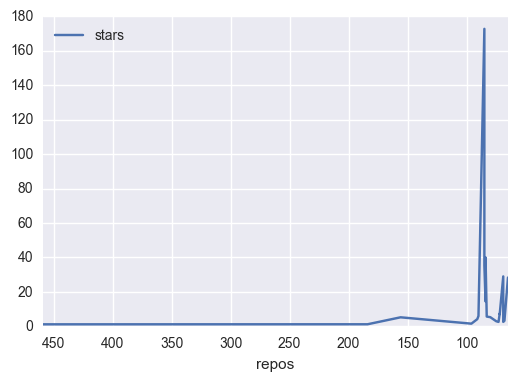

In [446]:
most_repos = df.owner.value_counts()[:20]
d = []
for person, repos in zip(most_repos.index, most_repos.values):
    print("%s\t %d stars\t%d repos" % (person, np.mean(df[df.owner == person].stars), repos))
    d.append({'stars': np.mean(df[df.owner == person].stars), 'repos': repos})
new_df = pd.DataFrame(d)
new_df.plot(x='repos', y='stars')

In [454]:
num_users = len(df[df.type == 'User'])
num_orgs = len(df[df.type == 'Organization'])

print(map(df[df.type == 'User'].language_1.value_counts(), lambda x: x/num_users))
print(df[df.type == 'Organization'].language_1.value_counts()[:5])

TypeError: 'function' object is not iterable

# REPORT AND PRESENTATION NEED TO HAVES
Presentation:

1. How we obtained our data and how we incorporated it /combined it.

2. Data Analysis: info from project report; analysis of data; getting to know your data; statistics

3. Application of techniques learned in class; took results of techniques and gave intuitive interpretation of results. Techniques used. Conclusions. Surprises, Analysis. Has hypothesis(es) and results supported one another or did not verify hypothesis. If results did not support hypothesis, why? Lack of data, type of data, hypothesis incorrect?

Report:

- What we are going to say and figures in our poster. Script/touch points.

# Conclusions

In [272]:
# SOMETHING INTELLIGENT